In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

# read csv
df_loaded = pd.read_csv('sum_all_1d.csv', index_col=0)
kettle_real = df_loaded.loc['Kettle0.npz']
pd_timestamp = df_loaded.columns.tolist()

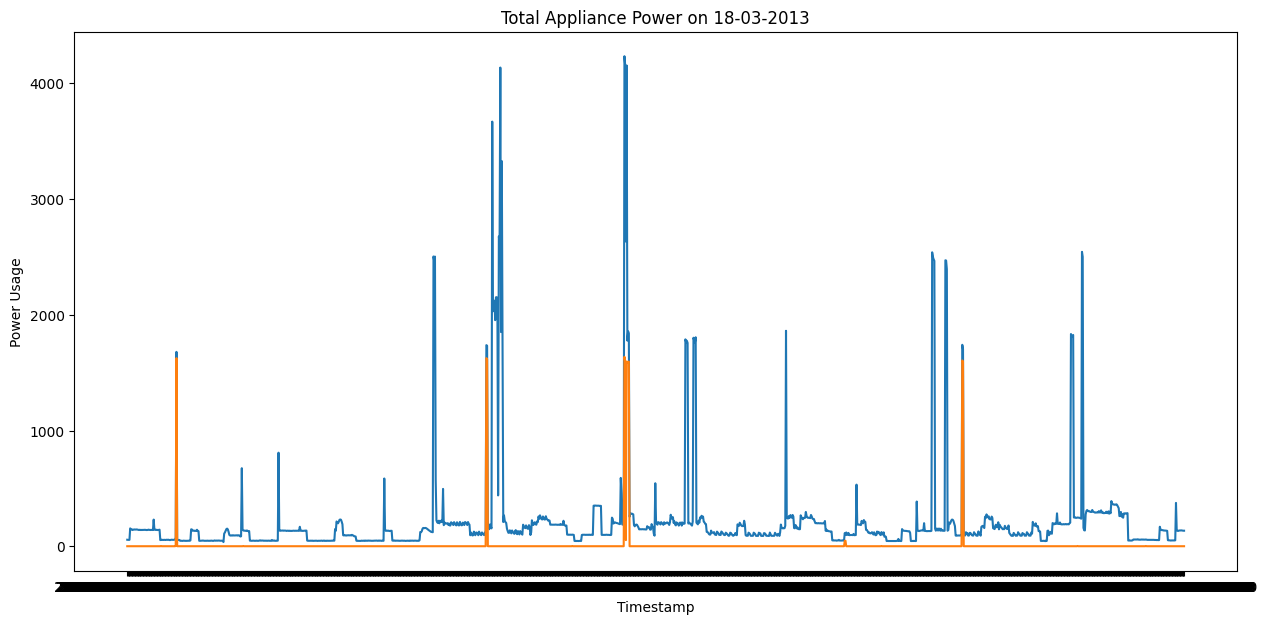

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(pd_timestamp,df_loaded.loc['Total Usage'])
plt.plot(pd_timestamp, df_loaded.loc['Microwave0.npz'])
plt.title('Total Appliance Power on 18-03-2013')
plt.xlabel('Timestamp')
plt.ylabel('Power Usage')
plt.show()
plt.close()

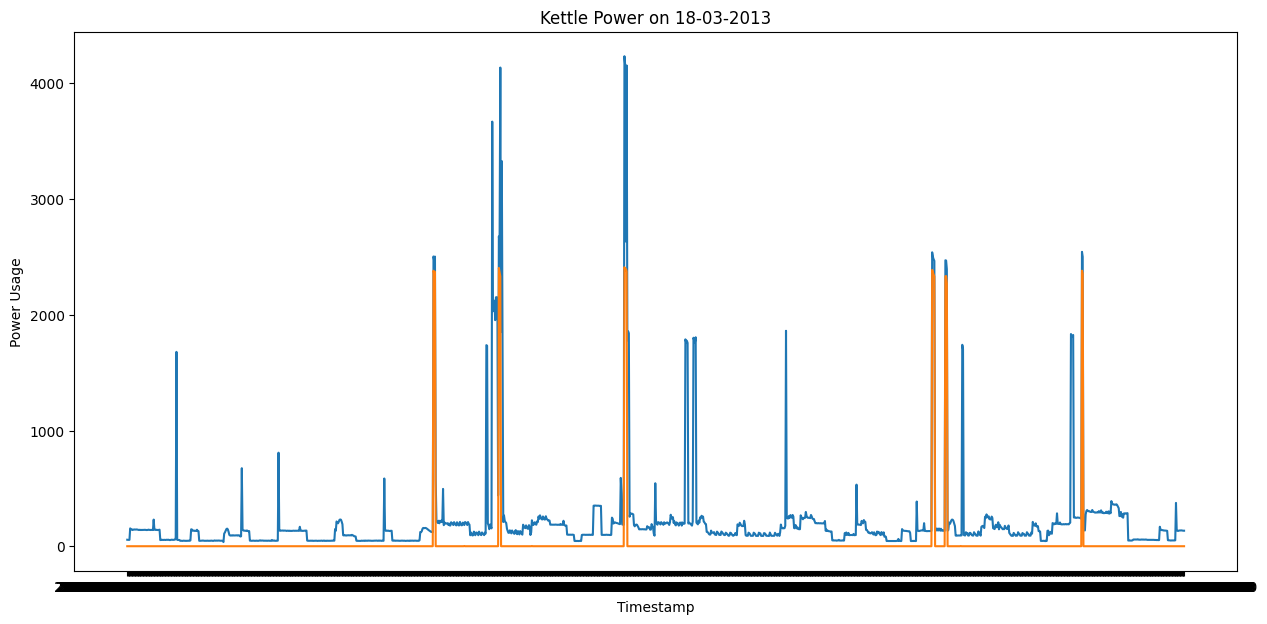

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(pd_timestamp,df_loaded.loc['Total Usage'])
plt.plot(pd_timestamp, df_loaded.loc['Kettle0.npz'])
plt.title('Kettle Power on 18-03-2013')
plt.xlabel('Timestamp')
plt.ylabel('Power Usage')
plt.show()
plt.close()

In [3]:
# Neural Network Model
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau


class Seq2PointNet(nn.Module):
    def __init__(self):
        super(Seq2PointNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.mean(x, 2) # Global Average Pooling
        x = self.fc(x)
        return x

class ImprovedTCNModel(nn.Module):
    def __init__(self, input_length):
        super(ImprovedTCNModel, self).__init__()
        self.tcn1 = TCNBlock(in_channels=1, out_channels=64, kernel_size=3, dilation=1)  # Increased filters
#         self.tcn2 = TCNBlock(in_channels=64, out_channels=64, kernel_size=3, dilation=2)
        self.tcn3 = TCNBlock(in_channels=64, out_channels=32, kernel_size=3, dilation=2)
        self.tcn4 = TCNBlock(in_channels=32, out_channels=4, kernel_size=3, dilation=4)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(input_length * 4, 512)  # Increased units
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Reduced dropout rate
        self.dense2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.tcn1(x)
#         x = self.tcn2(x)
        x = self.tcn3(x)
        x = self.tcn4(x)
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

def create_sequences(data, sequence_length):
    pad_size = sequence_length // 2
    padded_data = np.pad(data, (pad_size, pad_size), 'mean')
    sequences = []
    for i in range(len(data)):
        seq = padded_data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

# read data
# df = pd.read_csv('/mnt/data/sum_all_1d.csv')

# Training data prepare
df_10 = pd.read_csv('sum_no_light.csv', index_col=0)
X_train = df_10.loc['Total Usage'].values
y_train = df_10.loc['Kettle0.npz'].values

# Test data prepare
df_1 = pd.read_csv('sum_all_1d.csv', index_col=0)
X_test = df_1.loc['Total Usage'].values
y_test = df_1.loc['Kettle0.npz'].values

In [ ]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


sequence_length = 5
input_sequences = create_sequences(X_train, sequence_length)
target_sequences = y_train

# To PyTorch tensor
input_sequences = torch.tensor(input_sequences, dtype=torch.float32).unsqueeze(1)
target_sequences = torch.tensor(target_sequences, dtype=torch.float32).unsqueeze(1)

input_sequences = input_sequences.to(device)
target_sequences = target_sequences.to(device)


# Create the model
model = Seq2PointNet().to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


scheduler = StepLR(optimizer, step_size=2000, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
# Training Loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(input_sequences)
    loss = criterion(outputs, target_sequences)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')



Using device: cuda
Epoch 0, Loss: 58110.046875
Epoch 10, Loss: 46522.40625
Epoch 20, Loss: 39212.94140625
Epoch 30, Loss: 36030.0625
Epoch 40, Loss: 34797.2578125
Epoch 50, Loss: 33913.59375
Epoch 60, Loss: 33149.5078125
Epoch 70, Loss: 32517.23828125
Epoch 80, Loss: 32000.60546875
Epoch 90, Loss: 31508.111328125
Epoch 100, Loss: 31097.75390625
Epoch 110, Loss: 30695.845703125
Epoch 120, Loss: 30524.08984375
Epoch 130, Loss: 30102.57421875
Epoch 140, Loss: 29796.484375
Epoch 150, Loss: 29466.365234375
Epoch 160, Loss: 29158.7890625
Epoch 170, Loss: 28885.6015625
Epoch 180, Loss: 28676.5078125
Epoch 190, Loss: 28419.529296875
Epoch 200, Loss: 28323.26953125
Epoch 210, Loss: 27861.560546875
Epoch 220, Loss: 27737.95703125
Epoch 230, Loss: 27560.99609375
Epoch 240, Loss: 27449.150390625
Epoch 250, Loss: 27146.18359375
Epoch 260, Loss: 26828.533203125
Epoch 270, Loss: 26642.166015625
Epoch 280, Loss: 26465.337890625
Epoch 290, Loss: 26336.80078125
Epoch 300, Loss: 26307.884765625
Epoch 310

In [ ]:
torch.save(model.state_dict(), 'nilm_kettle.pth')

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

# Training data prepare
df_10 = pd.read_csv('sum_no_light.csv', index_col=0)
X_train = df_10.loc['Total Usage'].values
y_train = df_10.loc['Toaster0.npz'].values

# Test data prepare
df_1 = pd.read_csv('sum_all_1d.csv', index_col=0)
X_test = df_1.loc['Total Usage'].values
y_test = df_1.loc['Toaster0.npz'].values

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


sequence_length = 5
input_sequences = create_sequences(X_train, sequence_length)
target_sequences = y_train

# To PyTorch tensor
input_sequences = torch.tensor(input_sequences, dtype=torch.float32).unsqueeze(1)
target_sequences = torch.tensor(target_sequences, dtype=torch.float32).unsqueeze(1)

input_sequences = input_sequences.to(device)
target_sequences = target_sequences.to(device)


# Create the model
del model
model = Seq2PointNet().to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


scheduler = StepLR(optimizer, step_size=4000, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
# Training Loop
num_epochs = 22000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(input_sequences)
    loss = criterion(outputs, target_sequences)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

torch.save(model.state_dict(), 'nilm_toaster.pth')

Using device: cuda
Epoch 0, Loss: 37719.21875
Epoch 10, Loss: 30161.44140625
Epoch 20, Loss: 28982.134765625
Epoch 30, Loss: 27826.529296875
Epoch 40, Loss: 27032.73828125
Epoch 50, Loss: 26345.5390625
Epoch 60, Loss: 25833.98046875
Epoch 70, Loss: 25410.7578125
Epoch 80, Loss: 25046.193359375
Epoch 90, Loss: 24677.876953125
Epoch 100, Loss: 24310.822265625
Epoch 110, Loss: 23980.431640625
Epoch 120, Loss: 23694.134765625
Epoch 130, Loss: 23416.72265625
Epoch 140, Loss: 23209.787109375
Epoch 150, Loss: 22978.34375
Epoch 160, Loss: 22742.982421875
Epoch 170, Loss: 22557.525390625
Epoch 180, Loss: 22395.7109375
Epoch 190, Loss: 22289.453125
Epoch 200, Loss: 22091.4921875
Epoch 210, Loss: 21953.716796875
Epoch 220, Loss: 21885.349609375
Epoch 230, Loss: 21830.345703125
Epoch 240, Loss: 21697.37109375
Epoch 250, Loss: 21517.2734375
Epoch 260, Loss: 21473.4765625
Epoch 270, Loss: 21330.755859375
Epoch 280, Loss: 21259.619140625
Epoch 290, Loss: 21175.2734375
Epoch 300, Loss: 21198.0625
Epoc

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [ ]:
DDQL_MI_results = np.load('DDQL-MI_results.npy')
DQN1_results = np.load('DQN_v1.npy')
DQN07_results = np.load('DQN_v07.npy')
DQN03_results = np.load('DQN_v03.npy')
DQN0_results = np.load('DQN_V0_0.npy')

Kettle !!


In [ ]:
# Load model
# Kettle:
del model
model = Seq2PointNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('nilm_kettle.pth', map_location=device))
model.eval()

# Test data prepare
df_1 = pd.read_csv('sum_all_1d.csv', index_col=0)
X_test = df_1.loc['Total Usage'].values
y_test = df_1.loc['Kettle0.npz'].values


# For prediction
test_sequences = X_test # New sequences for prediction in NumPy array


# 使用长度为5的滑动窗口创建序列和目标值
sequence_length = 5
test_sequences = create_sequences(test_sequences, sequence_length)

# 转换为 PyTorch tensor
test_sequences = torch.tensor(test_sequences, dtype=torch.float32).unsqueeze(1).to(device)

predicted_usage = model(test_sequences).to(device)
predicted_usage = predicted_usage.cpu().detach().numpy() # Convert back to NumPy array if needed

def prediction(input_ndarray):
    sequence_length = 5
    test_sequences = create_sequences(input_ndarray, sequence_length)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32).unsqueeze(1).to(device)
    predicted_usage = model(test_sequences).to(device)
    predicted_usage = predicted_usage.cpu().detach().numpy()
    return predicted_usage

# For prediction
test_sequences = X_test # New sequences for prediction in NumPy array

masked_pred_dqn1 = prediction(DQN1_results)
masked_pred_dqn7 = prediction(DQN07_results)
masked_pred_dqn3 = prediction(DQN03_results)
masked_pred_dqn0 = prediction(DQN0_results)
masked_pred_ddql_mi = prediction(DDQL_MI_results)
predicted_usage_abs = [abs(i) for i in predicted_usage]
ddql_mi_abs =  [abs(i) for i in masked_pred_ddql_mi]
dqn1_abs = [abs(i) for i in masked_pred_dqn1]
dqn7_abs = [abs(i) for i in masked_pred_dqn7]
dqn3_abs = [abs(i) for i in masked_pred_dqn3]
dqn0_abs = [abs(i) for i in masked_pred_dqn0]
dqn1_abs_kw = [x/1000 for x in dqn1_abs]
ddql_mi_abs_kw = [x/1000 for x in ddql_mi_abs]
predicted_usage_abs_kw = [x/1000 for x in predicted_usage_abs]
kettle_origin_kw = [x/1000 for x in y_test]

kettle_onoff = [1 if x > 0.5 else 0 for x in kettle_origin_kw]
nilm_onoff = [1 if x > 0.5 else 0 for x in predicted_usage_abs_kw]
ddql_onoff = [1 if x > 0.5 else 0 for x in ddql_mi_abs_kw]
dqn_onoff = [1 if x > 0.5 else 0 for x in dqn1_abs_kw]

dqn7_onoff = [1 if x > 500 else 0 for x in dqn7_abs]
dqn3_onoff = [1 if x > 500 else 0 for x in dqn3_abs]
dqn0_onoff = [1 if x > 500 else 0 for x in dqn0_abs]


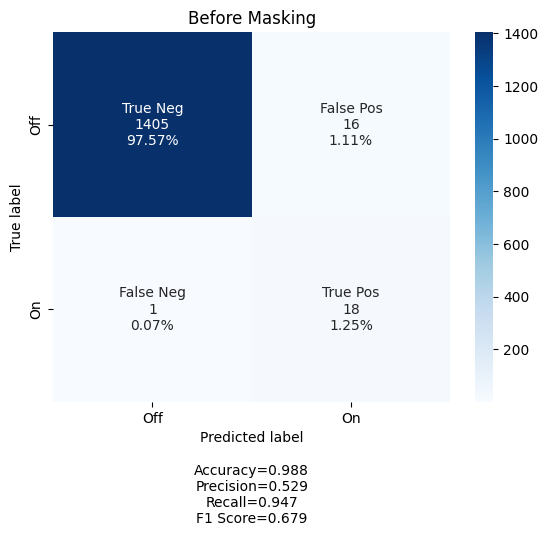

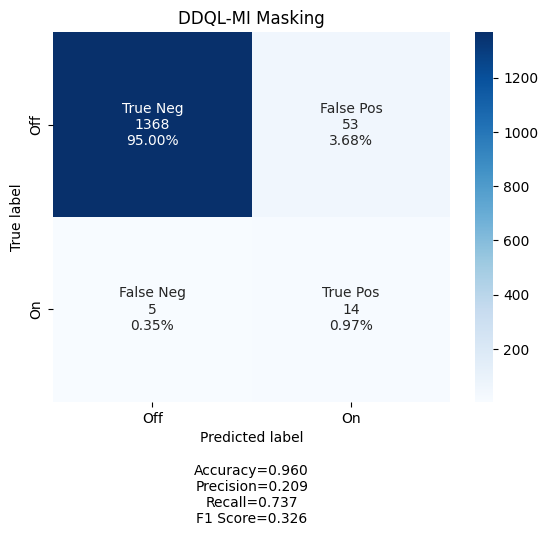

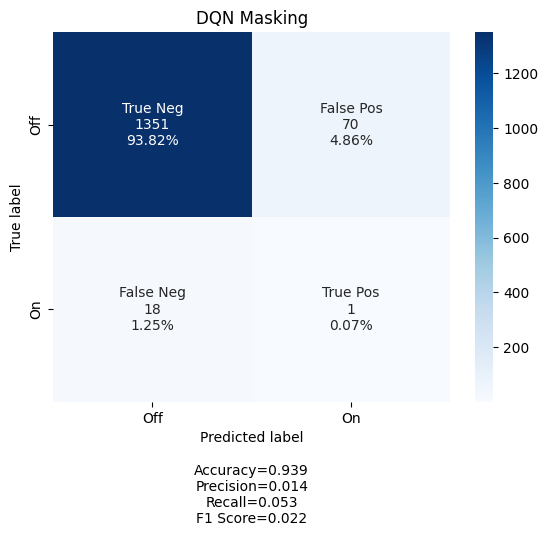

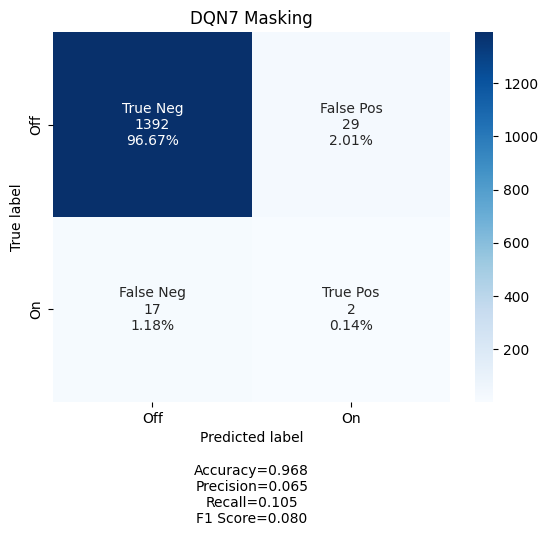

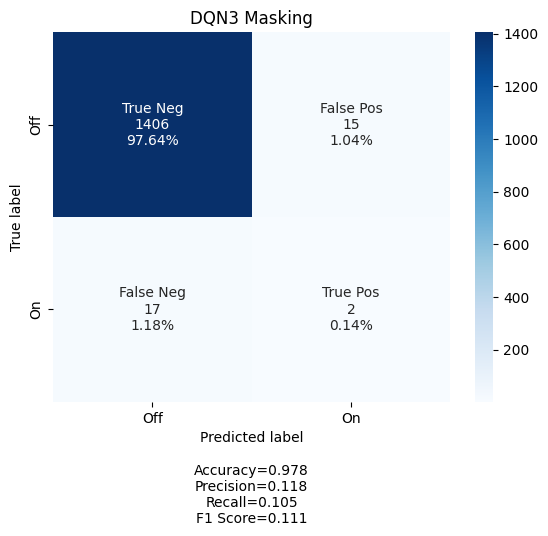

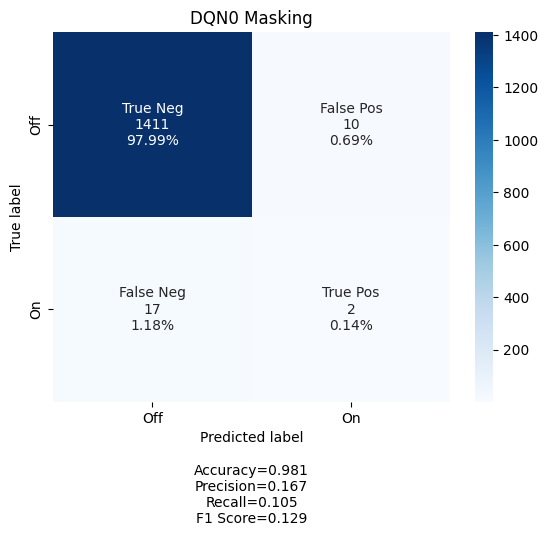

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

confusion_matrix_unmasked = confusion_matrix(kettle_onoff,nilm_onoff)
confusion_matrix_ddql = confusion_matrix(kettle_onoff,ddql_onoff)
confusion_matrix_dqn = confusion_matrix(kettle_onoff,dqn_onoff)

confusion_matrix_dqn7 = confusion_matrix(kettle_onoff,dqn7_onoff)
confusion_matrix_dqn3 = confusion_matrix(kettle_onoff,dqn3_onoff)
confusion_matrix_dqn0 = confusion_matrix(kettle_onoff,dqn0_onoff)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Off', 'On']
make_confusion_matrix(confusion_matrix_unmasked,
                      group_names=labels,
                      categories=categories,
                      title='Before Masking')
make_confusion_matrix(confusion_matrix_ddql,
                      group_names=labels,
                      categories=categories,
                      title='DDQL-MI Masking')
make_confusion_matrix(confusion_matrix_dqn,
                      group_names=labels,
                      categories=categories,
                      title='DQN Masking')

make_confusion_matrix(confusion_matrix_dqn7,
                      group_names=labels,
                      categories=categories,
                      title='DQN7 Masking')
make_confusion_matrix(confusion_matrix_dqn3,
                      group_names=labels,
                      categories=categories,
                      title='DQN3 Masking')
make_confusion_matrix(confusion_matrix_dqn0,
                      group_names=labels,
                      categories=categories,
                      title='DQN0 Masking')

In [ ]:
plt.rcParams.update({'font.size': 12}) # 改变所有字体大小，改变其他性质类似

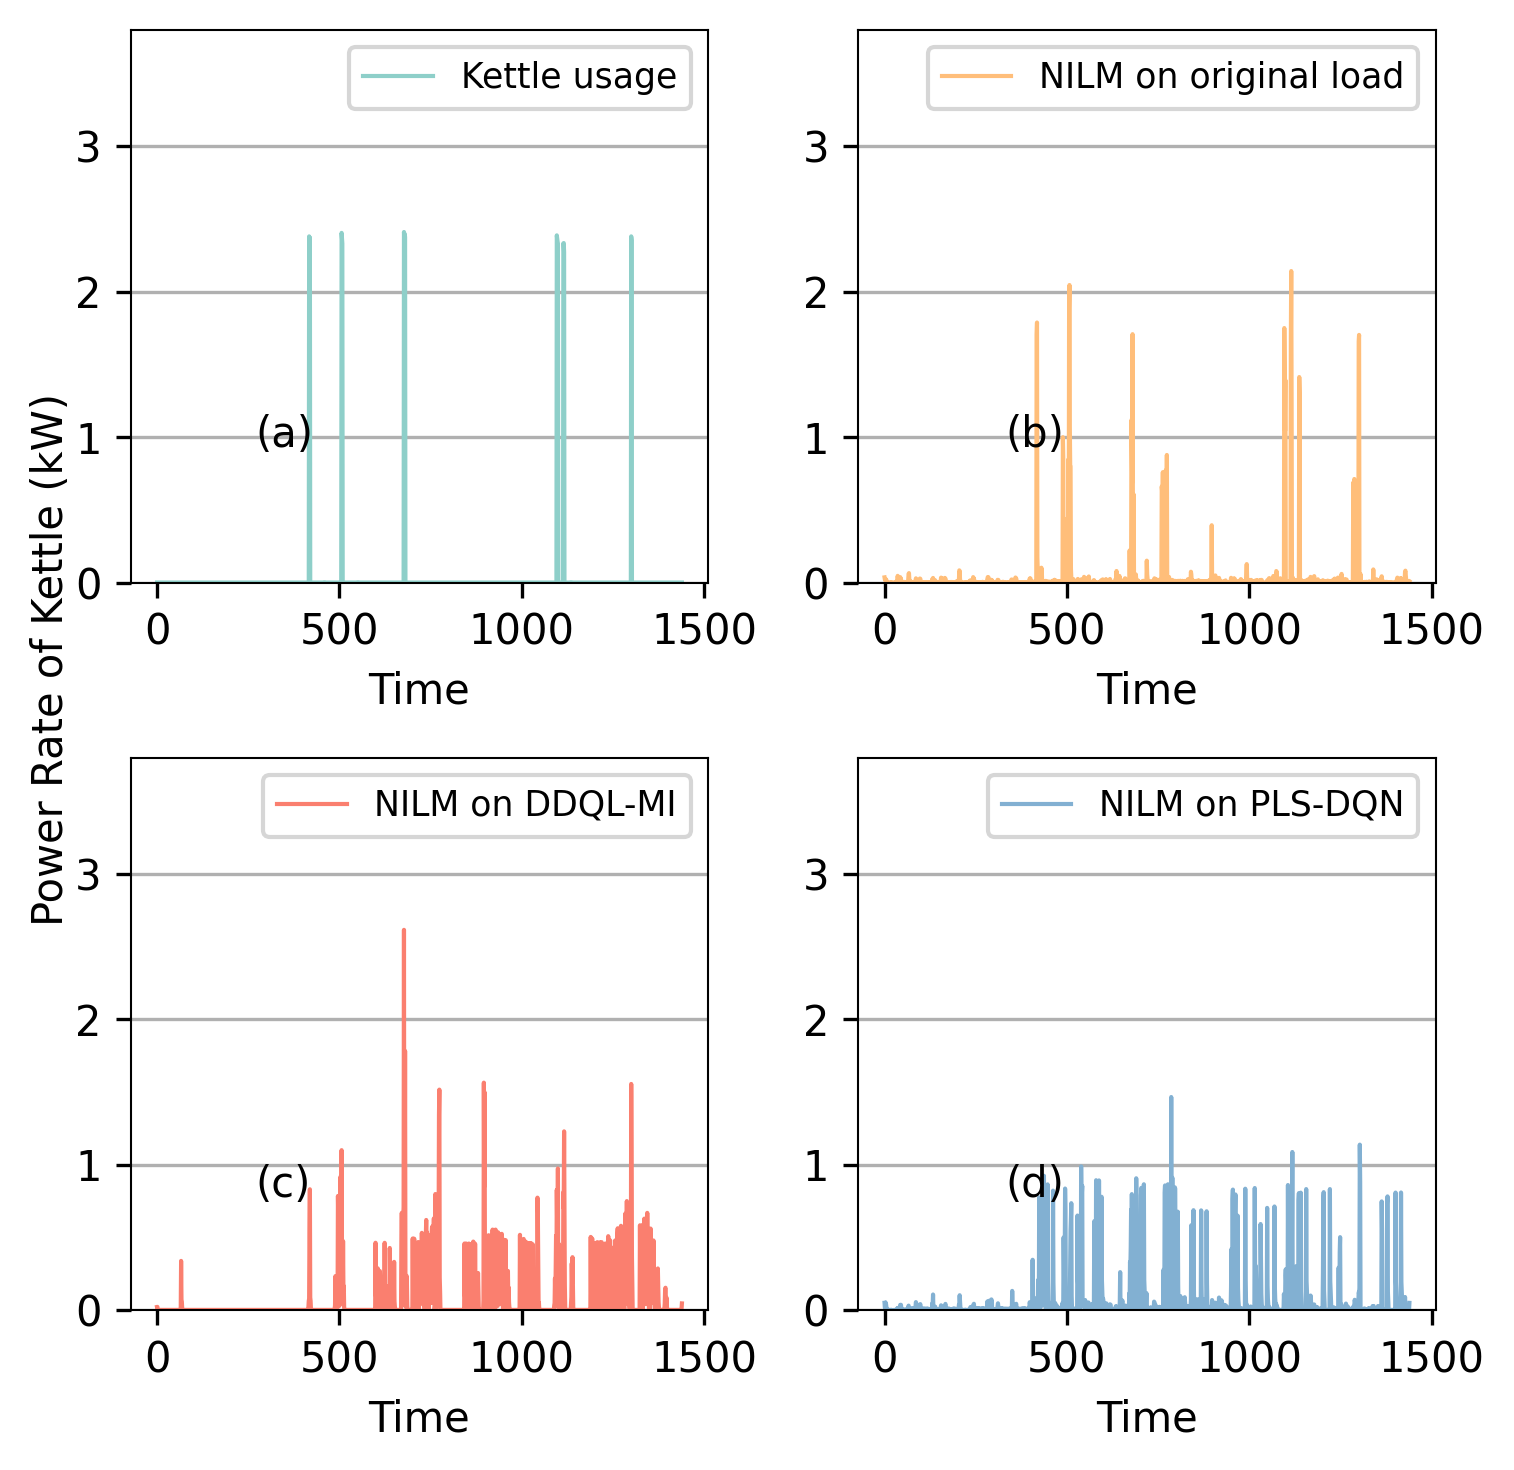

In [ ]:
# 创建一个新的figure和子图，设置更高的dpi值
plt.figure(figsize=(5, 5), dpi=300)
colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2']
legend_fontsize = 'small'
y_min_scaled, y_max_scaled = 0,3.8
# 设置每个子图边框的宽度
border_width = 0.5  # 边框宽度减少

# 第一个子图
ax1 = plt.subplot(221)
ax1.plot(kettle_origin_kw, label='Kettle usage', linewidth=1,color=colors[0])
ax1.set_ylim([y_min_scaled, y_max_scaled])
ax1.legend(fontsize=legend_fontsize)
# ax1.set_xticks([])  # 移除x轴刻度
ax1.set_xlabel('Time')
ax1.grid(True, which='both', axis='y')
for spine in ax1.spines.values():
    spine.set_linewidth(border_width)

# 第二个子图
ax2 = plt.subplot(222)
ax2.plot(predicted_usage_abs_kw, label='NILM on original load', linewidth=1,color=colors[1])
ax2.set_ylim([y_min_scaled, y_max_scaled])
ax2.legend(fontsize=legend_fontsize,loc='upper right')
# ax2.set_xticks([])  # 移除x轴刻度
ax2.set_xlabel('Time')
ax2.grid(True, which='both', axis='y')
for spine in ax2.spines.values():
    spine.set_linewidth(border_width)

# 第三个子图
ax3 = plt.subplot(223)
ax3.plot(ddql_mi_abs_kw, label='NILM on DDQL-MI', linewidth=1,color=colors[2])
ax3.set_ylim([y_min_scaled, y_max_scaled])
ax3.legend(fontsize=legend_fontsize)
# ax3.set_xticks([])  # 移除x轴刻度
ax3.set_xlabel('Time')
ax3.grid(True, which='both', axis='y')
for spine in ax3.spines.values():
    spine.set_linewidth(border_width)

# 第四个子图
ax4 = plt.subplot(224)
ax4.plot(dqn1_abs_kw, label='NILM on PLS-DQN', linewidth=1,color=colors[3])
ax4.set_ylim([y_min_scaled, y_max_scaled])
ax4.legend(fontsize=legend_fontsize)
# ax4.set_xticks([])  # 移除x轴刻度
ax4.set_xlabel('Time')
# ax4.set_yticks([])
ax4.grid(True, which='both', axis='y')
for spine in ax4.spines.values():
    spine.set_linewidth(border_width)


plt.subplots_adjust(hspace=0)
plt.figtext(0, 0.55, 'Power Rate of Kettle (kW)', va='center', rotation='vertical')
plt.figtext(0.15, 0.7, '(a)', va='center')
plt.figtext(0.15, 0.2, '(c)', va='center')
plt.figtext(0.65, 0.7, '(b)', va='center')
plt.figtext(0.65, 0.2, '(d)', va='center')


plt.tight_layout()
plt.show()

In [ ]:
# Load model
# toaster:
del model
model = Seq2PointNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('nilm_toaster.pth', map_location=device))
model.eval()

# Test data prepare
df_1 = pd.read_csv('sum_all_1d.csv', index_col=0)
X_test = df_1.loc['Total Usage'].values
y_test = df_1.loc['Toaster0.npz'].values

# For prediction
test_sequences = X_test # New sequences for prediction in NumPy array


# 使用长度为5的滑动窗口创建序列和目标值
sequence_length = 5
test_sequences = create_sequences(test_sequences, sequence_length)

# 转换为 PyTorch tensor
test_sequences = torch.tensor(test_sequences, dtype=torch.float32).unsqueeze(1).to(device)

predicted_usage = model(test_sequences).to(device)
predicted_usage = predicted_usage.cpu().detach().numpy() # Convert back to NumPy array if needed

def prediction(input_ndarray):
    sequence_length = 5
    test_sequences = create_sequences(input_ndarray, sequence_length)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32).unsqueeze(1).to(device)
    predicted_usage = model(test_sequences).to(device)
    predicted_usage = predicted_usage.cpu().detach().numpy()
    return predicted_usage

# For prediction
test_sequences = X_test # New sequences for prediction in NumPy array

masked_pred_dqn1 = prediction(DQN1_results)
masked_pred_dqn7 = prediction(DQN07_results)
masked_pred_dqn3 = prediction(DQN03_results)
masked_pred_dqn0 = prediction(DQN0_results)
masked_pred_ddql_mi = prediction(DDQL_MI_results)
predicted_usage_abs = [abs(i) for i in predicted_usage]
ddql_mi_abs =  [abs(i) for i in masked_pred_ddql_mi]
dqn1_abs = [abs(i) for i in masked_pred_dqn1]
dqn7_abs = [abs(i) for i in masked_pred_dqn7]
dqn3_abs = [abs(i) for i in masked_pred_dqn3]
dqn0_abs = [abs(i) for i in masked_pred_dqn0]
dqn1_abs_kw = [x/1000 for x in dqn1_abs]
ddql_mi_abs_kw = [x/1000 for x in ddql_mi_abs]
predicted_usage_abs_kw = [x/1000 for x in predicted_usage_abs]
toaster_origin_kw = [x/1000 for x in y_test]

In [ ]:
toaster_onoff = [1 if x > 0.5 else 0 for x in toaster_origin_kw]
nilm_onoff = [1 if x > 0.5 else 0 for x in predicted_usage_abs_kw]
ddql_onoff = [1 if x > 0.5 else 0 for x in ddql_mi_abs_kw]
dqn_onoff = [1 if x > 0.5 else 0 for x in dqn1_abs_kw]

dqn7_onoff = [1 if x > 500 else 0 for x in dqn7_abs]
dqn3_onoff = [1 if x > 500 else 0 for x in dqn3_abs]
dqn0_onoff = [1 if x > 500 else 0 for x in dqn0_abs]

<ipython-input-14-de40ab61a48b>:79: RuntimeWarning: invalid value encountered in scalar divide
  f1_score  = 2*precision*recall / (precision + recall)


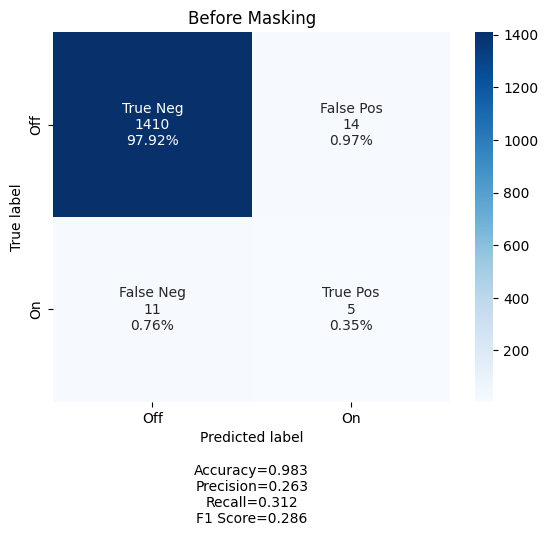

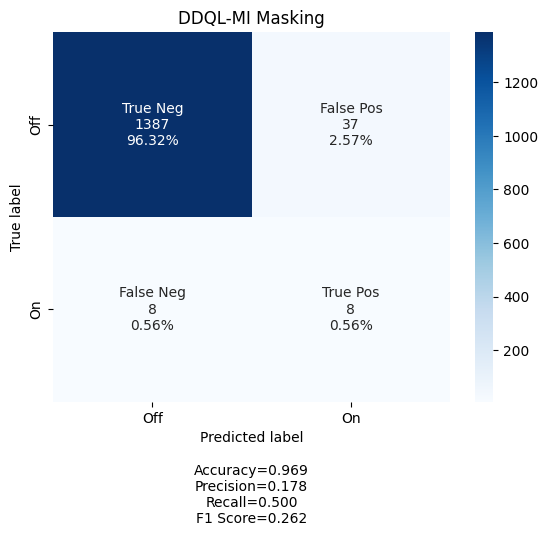

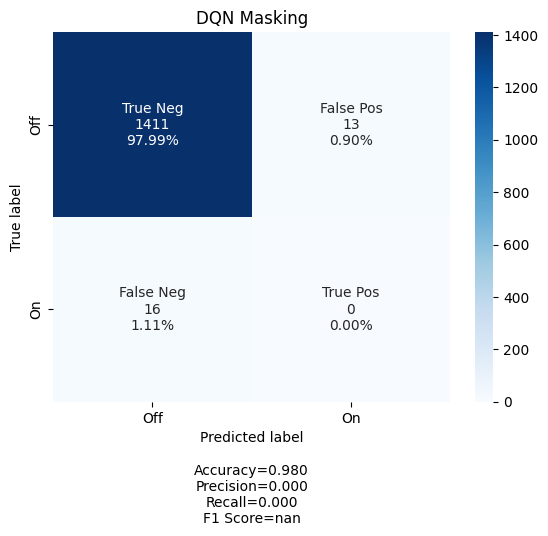

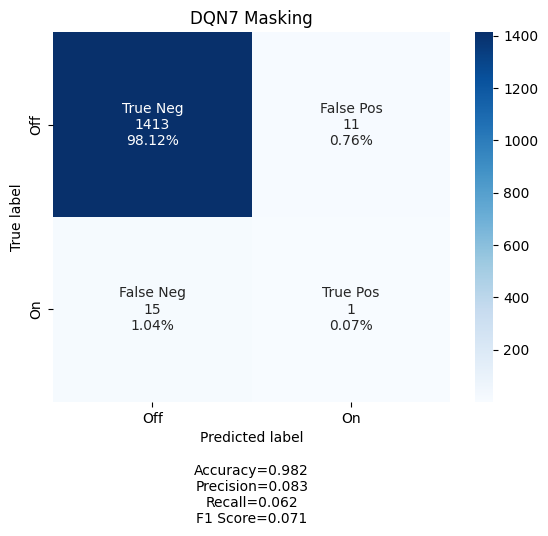

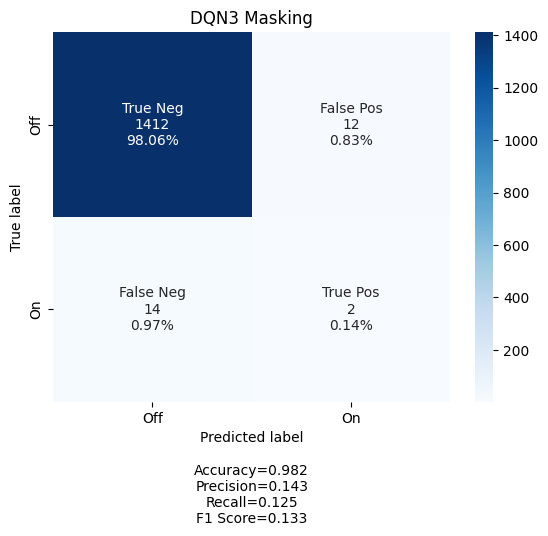

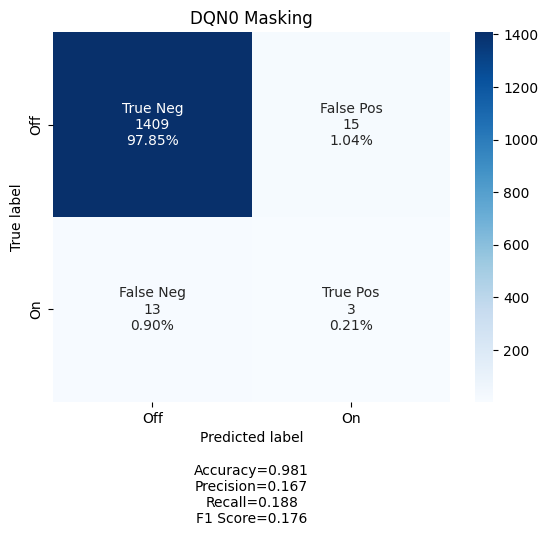

In [ ]:
confusion_matrix_unmasked = confusion_matrix(toaster_onoff,nilm_onoff)
confusion_matrix_ddql = confusion_matrix(toaster_onoff,ddql_onoff)
confusion_matrix_dqn = confusion_matrix(toaster_onoff,dqn_onoff)

confusion_matrix_dqn7 = confusion_matrix(toaster_onoff,dqn7_onoff)
confusion_matrix_dqn3 = confusion_matrix(toaster_onoff,dqn3_onoff)
confusion_matrix_dqn0 = confusion_matrix(toaster_onoff,dqn0_onoff)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Off', 'On']
make_confusion_matrix(confusion_matrix_unmasked,
                      group_names=labels,
                      categories=categories,
                      title='Before Masking')
make_confusion_matrix(confusion_matrix_ddql,
                      group_names=labels,
                      categories=categories,
                      title='DDQL-MI Masking')
make_confusion_matrix(confusion_matrix_dqn,
                      group_names=labels,
                      categories=categories,
                      title='DQN Masking')

make_confusion_matrix(confusion_matrix_dqn7,
                      group_names=labels,
                      categories=categories,
                      title='DQN7 Masking')
make_confusion_matrix(confusion_matrix_dqn3,
                      group_names=labels,
                      categories=categories,
                      title='DQN3 Masking')
make_confusion_matrix(confusion_matrix_dqn0,
                      group_names=labels,
                      categories=categories,
                      title='DQN0 Masking')

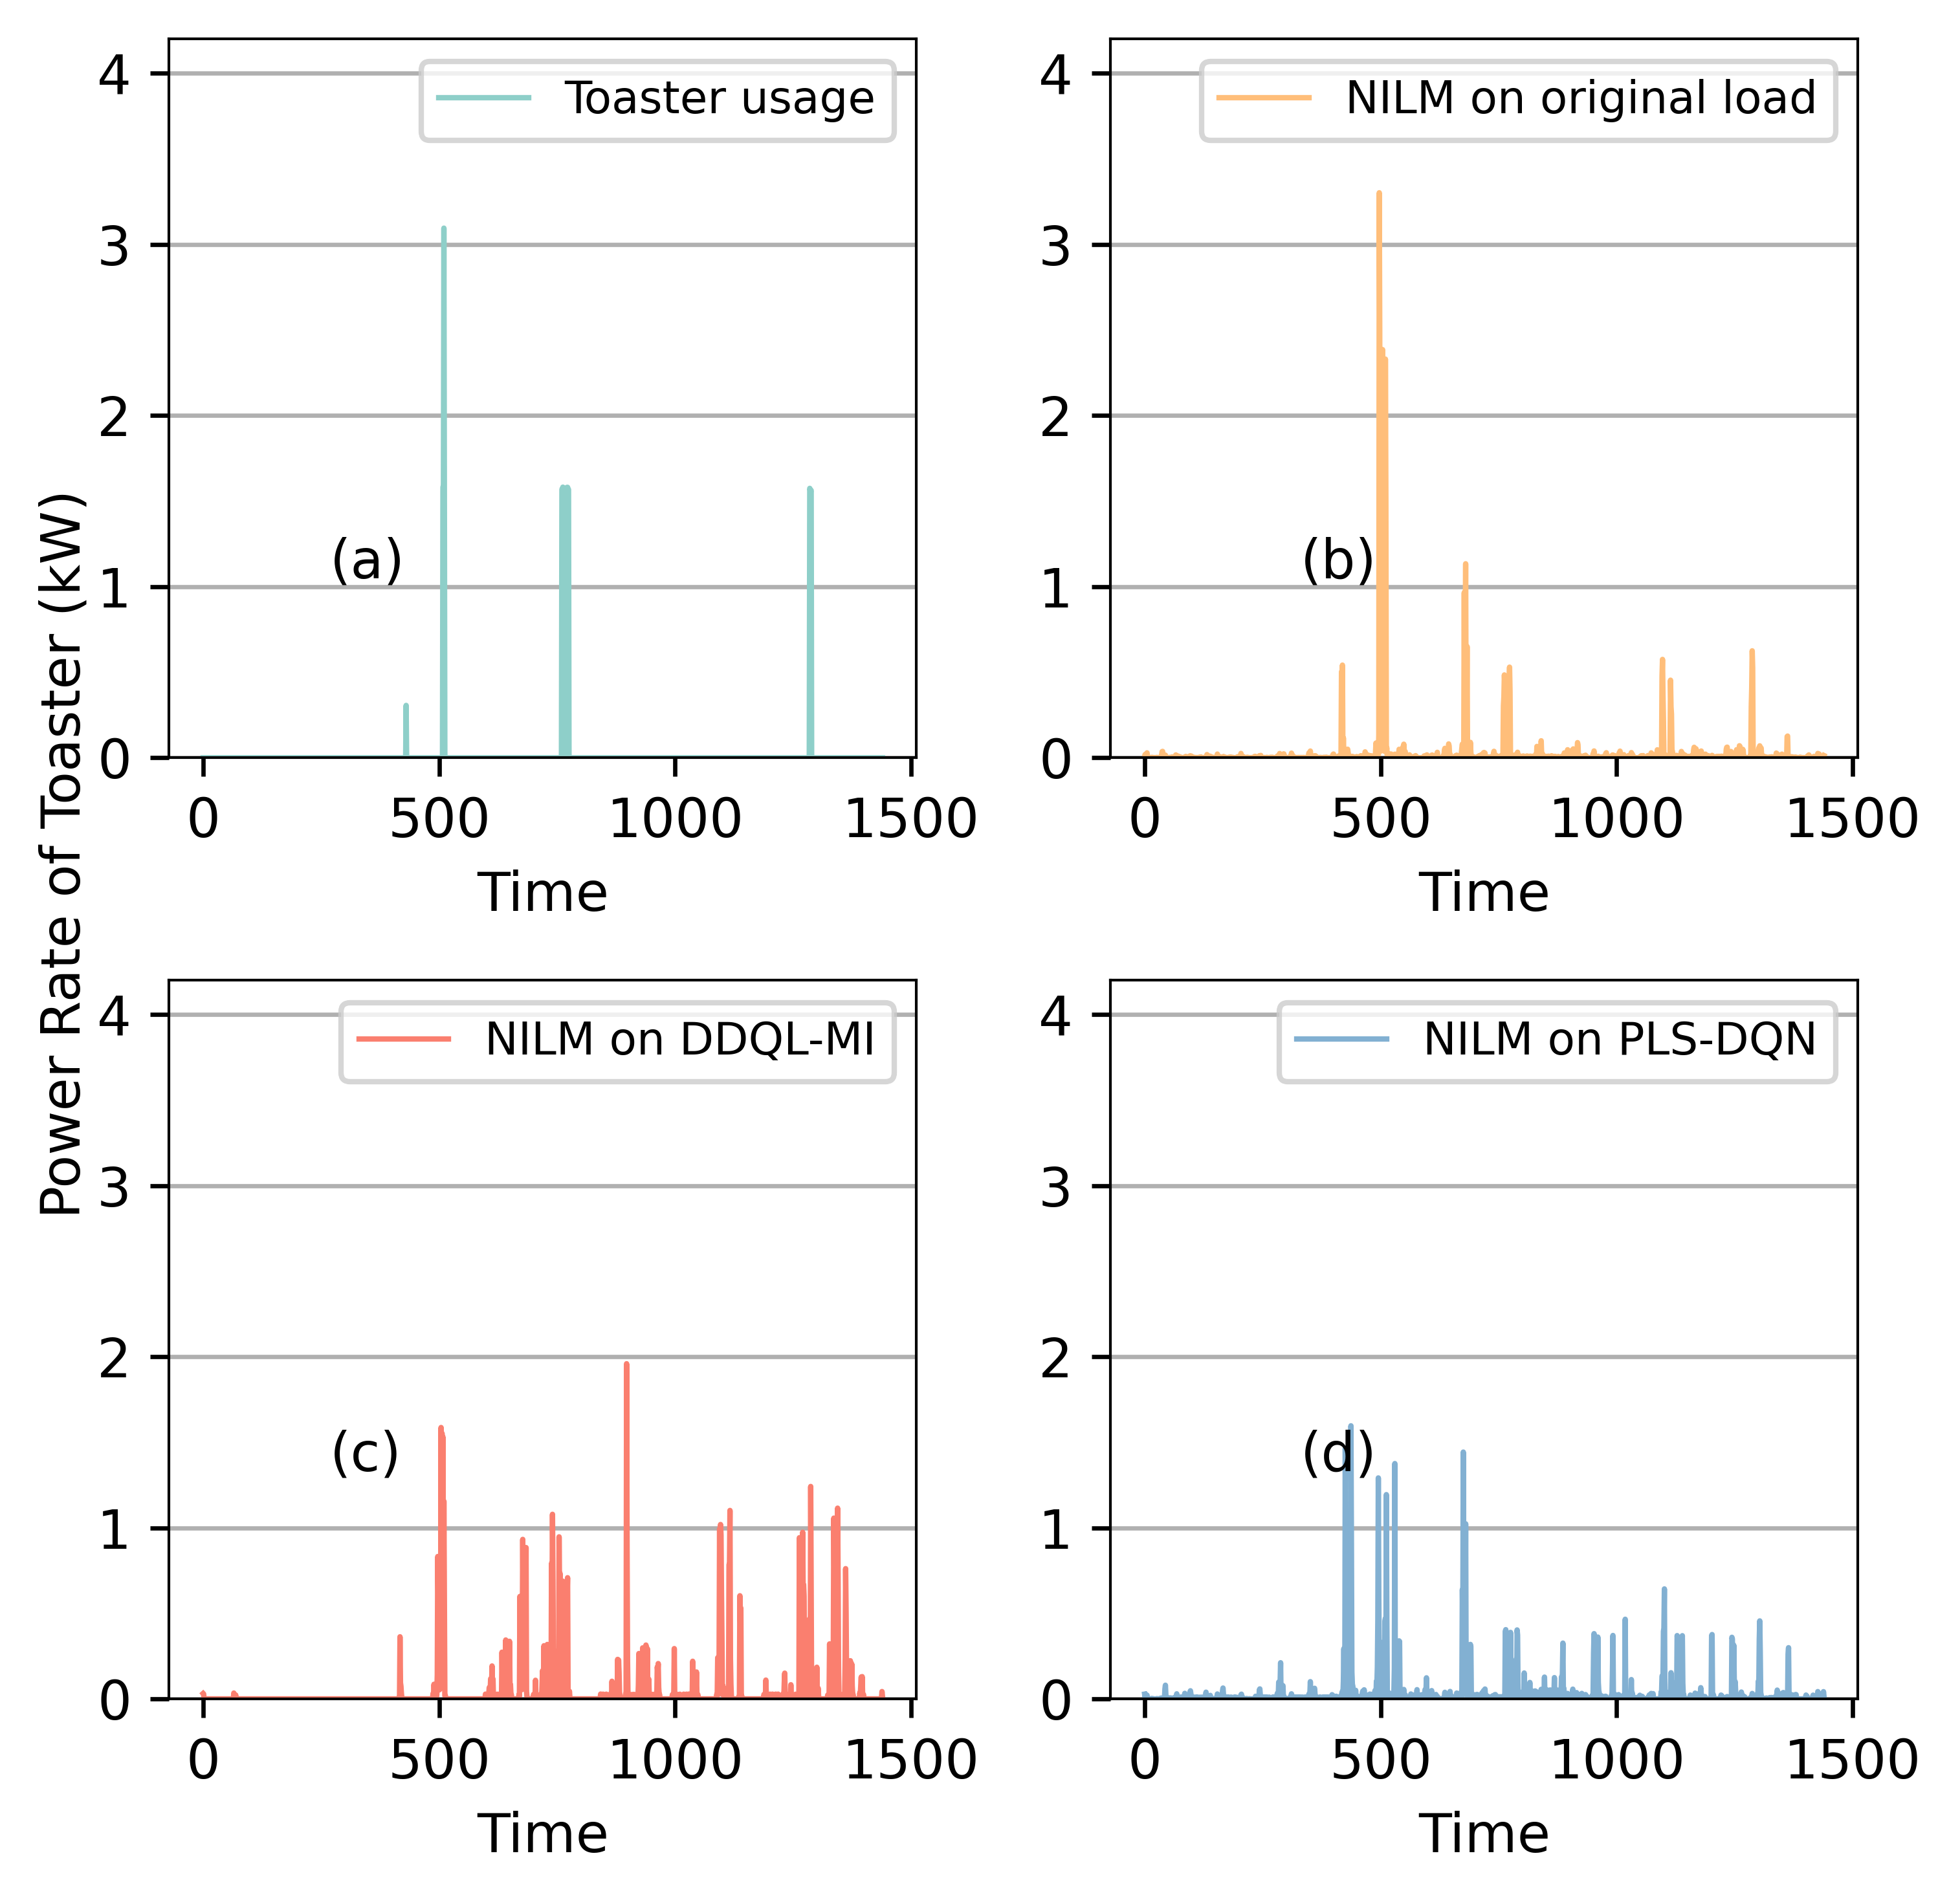

In [ ]:
# 创建一个新的figure和子图，设置更高的dpi值
plt.figure(figsize=(5,5), dpi=600)
colors = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2']

y_min_scaled, y_max_scaled = 0,4.2
# 设置每个子图边框的宽度
border_width = 0.5  # 边框宽度减少

# 第一个子图
ax1 = plt.subplot(221)
ax1.plot(toaster_origin_kw, label='Toaster usage', linewidth=1,color=colors[0])
ax1.set_ylim([y_min_scaled, y_max_scaled])
ax1.legend(fontsize=legend_fontsize)
# ax1.set_xticks([])  # 移除x轴刻度
ax1.set_xlabel('Time')
ax1.grid(True, which='both', axis='y')
for spine in ax1.spines.values():
    spine.set_linewidth(border_width)

# 第二个子图
ax2 = plt.subplot(222)
ax2.plot(predicted_usage_abs_kw, label='NILM on original load', linewidth=1,color=colors[1])
ax2.set_ylim([y_min_scaled, y_max_scaled])
ax2.legend(fontsize=legend_fontsize)
# ax2.set_xticks([])  # 移除x轴刻度
ax2.set_xlabel('Time')
ax2.grid(True, which='both', axis='y')
for spine in ax2.spines.values():
    spine.set_linewidth(border_width)

# 第三个子图
ax3 = plt.subplot(223)
ax3.plot(ddql_mi_abs_kw, label='NILM on DDQL-MI', linewidth=1,color=colors[2])
ax3.set_ylim([y_min_scaled, y_max_scaled])
ax3.legend(fontsize=legend_fontsize)
# ax3.set_xticks([])  # 移除x轴刻度
ax3.set_xlabel('Time')
ax3.grid(True, which='both', axis='y')
for spine in ax3.spines.values():
    spine.set_linewidth(border_width)

# 第四个子图
ax4 = plt.subplot(224)
ax4.plot(dqn1_abs_kw, label='NILM on PLS-DQN', linewidth=1,color=colors[3])
ax4.set_ylim([y_min_scaled, y_max_scaled])
ax4.legend(fontsize=legend_fontsize)
# ax4.set_xticks([])  # 移除x轴刻度
ax4.set_xlabel('Time')
# ax4.set_yticks([])
ax4.grid(True, which='both', axis='y')
for spine in ax4.spines.values():
    spine.set_linewidth(border_width)


plt.subplots_adjust(hspace=0)
plt.figtext(0, 0.55, 'Power Rate of Toaster (kW)', va='center', rotation='vertical')
plt.figtext(0.15, 0.7, '(a)', va='center')
plt.figtext(0.15, 0.24, '(c)', va='center')
plt.figtext(0.65, 0.7, '(b)', va='center')
plt.figtext(0.65, 0.24, '(d)', va='center')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(kettle_origin_kw)), kettle_origin, 'orange',label='Actual Usage',linewidth=5)
plt.plot(range(len(predicted_usage_abs_kw)), predicted_usage_abs_kw, label='Predicted Usage',linewidth=1)
plt.plot(range(len(ddql_mi_abs_kw)), ddql_mi_abs_kw, label='ddql-mi',linewidth=1)
plt.plot(range(len(dqn1_abs_kw)), dqn1_abs_kw, label='dqn',linewidth=1)
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()
plt.show()
plt.close()

NameError: name 'kettle_origin' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
def prediction(input_ndarray):
    sequence_length = 5
    test_sequences = create_sequences(input_ndarray, sequence_length)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32).unsqueeze(1).to(device)
    predicted_usage = model(test_sequences).to(device)
    predicted_usage = predicted_usage.cpu().detach().numpy()
    return predicted_usage

# For prediction
test_sequences = X_test # New sequences for prediction in NumPy array

masked_pred_dqn1 = prediction(DQN1_results)
masked_pred_dqn7 = prediction(DQN07_results)
masked_pred_dqn3 = prediction(DQN03_results)
masked_pred_dqn0 = prediction(DQN0_results)
masked_pred_ddql_mi = prediction(DDQL_MI_results)
predicted_usage_abs = [abs(i) for i in predicted_usage]
ddql_mi_abs = predicted_usage_abs = [abs(i) for i in masked_pred_ddql_mi]
dqn1_abs = [abs(i) for i in masked_pred_dqn1]
dqn7_abs = [abs(i) for i in masked_pred_dqn7]
dqn3_abs = [abs(i) for i in masked_pred_dqn3]
dqn0_abs = [abs(i) for i in masked_pred_dqn0]

DQN1_results_kw = DQN1_results/1000
DQN07_results_kw = DQN07_results/1000
DQN03_results_kw = DQN03_results/1000
DQN0_results_kw = DQN0_results/1000
DDQL_MI_results_kw = DDQL_MI_results/1000
origin_demand_kw = X_test/1000

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, 'orange',label='Actual Usage',linewidth=5)
plt.plot(range(len(predicted_usage)), prediction, label='Predicted Usage',linewidth=1)
plt.title('Comparison of Predicted and Actual Kettle Usage Before {} Masking'.format(name))
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()
plt.show()
plt.close()

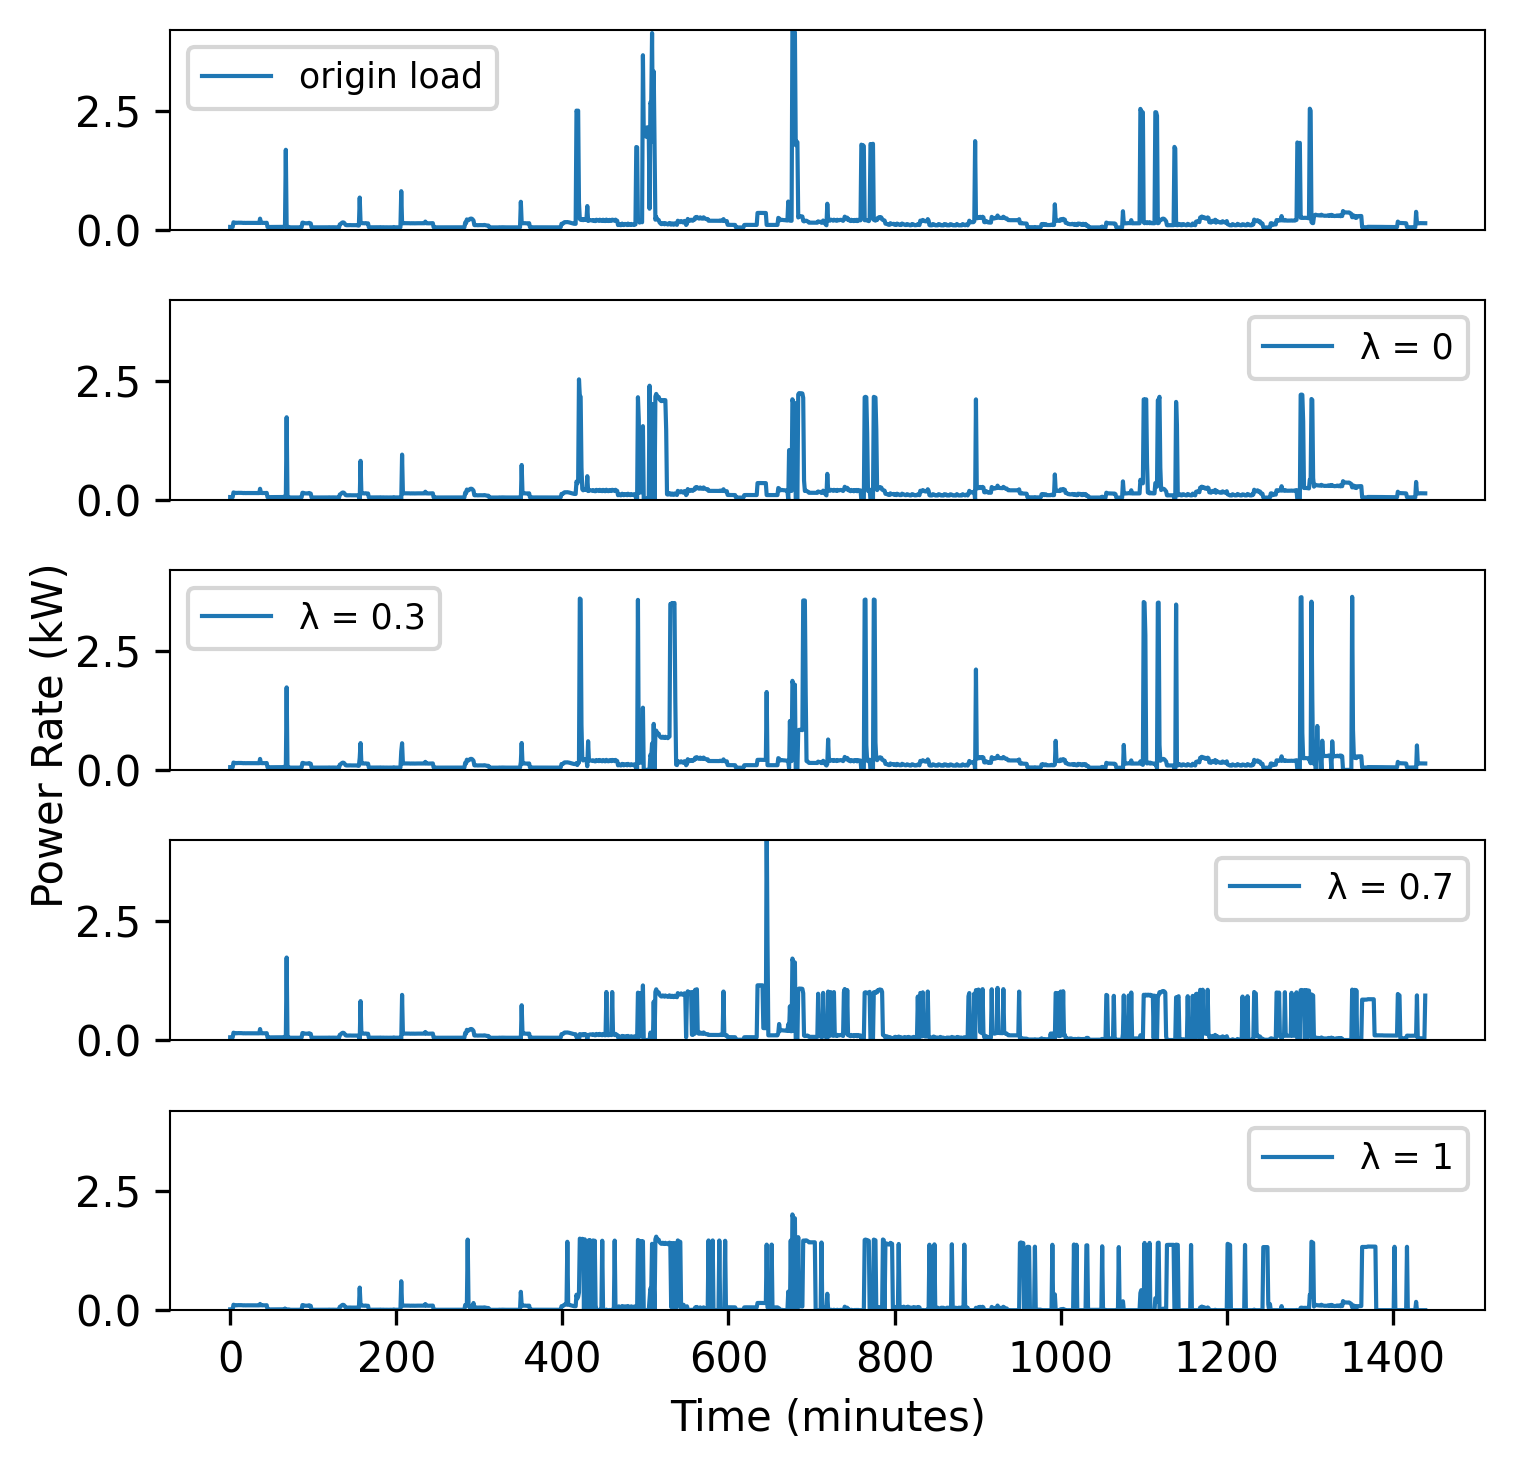

In [ ]:
# 创建一个新的figure和子图，设置更高的dpi值
plt.figure(figsize=(5, 5), dpi=300)
y_min_scaled, y_max_scaled = 0,4.2
# 设置每个子图边框的宽度
border_width = 0.5  # 边框宽度减少
legend_fontsize = 'small'
# 第一个子图
ax1 = plt.subplot(5, 1, 5)
ax1.plot(DQN1_results_kw, label='\u03BB = 1', linewidth=1)
ax1.set_ylim([y_min_scaled, y_max_scaled])
ax1.legend(fontsize=legend_fontsize)

ax1.set_xlabel('Time (minutes)')
for spine in ax1.spines.values():
    spine.set_linewidth(border_width)

# 第二个子图
ax2 = plt.subplot(5, 1, 4)
ax2.plot(DQN07_results_kw, label='\u03BB = 0.7', linewidth=1)
ax2.set_ylim([y_min_scaled, y_max_scaled])
ax2.legend(fontsize=legend_fontsize)
ax2.set_xticks([])  # 移除x轴刻度
for spine in ax2.spines.values():
    spine.set_linewidth(border_width)

# 第三个子图
ax3 = plt.subplot(5, 1, 3)
ax3.plot(DQN03_results_kw, label='\u03BB = 0.3', linewidth=1)
ax3.set_ylim([y_min_scaled, y_max_scaled])
ax3.legend(fontsize=legend_fontsize)
ax3.set_xticks([])  # 移除x轴刻度
for spine in ax3.spines.values():
    spine.set_linewidth(border_width)

# 第四个子图
ax4 = plt.subplot(5, 1, 2)
ax4.plot(DQN0_results_kw, label='\u03BB = 0', linewidth=1)
ax4.set_ylim([y_min_scaled, y_max_scaled])
ax4.legend(fontsize=legend_fontsize)
ax4.set_xticks([])  # 移除x轴刻度
for spine in ax4.spines.values():
    spine.set_linewidth(border_width)

ax5 = plt.subplot(5, 1, 1)
ax5.plot(origin_demand_kw, label='origin load', linewidth=1)
ax5.set_xticks([])  # 移除x轴刻度
ax5.set_ylim([y_min_scaled, y_max_scaled])
ax5.legend(fontsize=legend_fontsize)
for spine in ax5.spines.values():
    spine.set_linewidth(border_width)


plt.subplots_adjust(hspace=0)
plt.figtext(0, 0.5, 'Power Rate (kW)', va='center', rotation='vertical')


plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(range(len(origin_demand_kw)), origin_demand_kw, 'orange',label='Original load demand',linewidth=3)
plt.plot(range(len(DQN1_results_kw)), DQN1_results_kw, label='Masked demand by PLS-DQN ',linewidth=1)
# plt.title('Comparison of Predicted and Actual Kettle Usage Before {} Masking'.format(name))
plt.xlabel('Time')
plt.ylabel('Power Rate (kW)')
plt.legend()
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(range(len(origin_demand_kw)), origin_demand_kw, 'orange',label='Original load demand',linewidth=3)
plt.plot(range(len(DDQL_MI_results_kw)), DDQL_MI_results_kw, label='Masked demand by DDQL-MI ',linewidth=1)
# plt.title('Comparison of Predicted and Actual Kettle Usage Before {} Masking'.format(name))
plt.xlabel('Time')
plt.ylabel('Power Rate (kW)')
plt.legend()
plt.show()
plt.close()

In [ ]:
def plot_prediction_kettle(y_test, masked_prediction, prediction, name):

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, 'orange',label='Actual Usage',linewidth=5)
    plt.plot(range(len(predicted_usage)), prediction, label='Predicted Usage',linewidth=1)
    plt.title('Comparison of Predicted and Actual Kettle Usage Before {} Masking'.format(name))
    plt.xlabel('Time')
    plt.ylabel('Usage')
    plt.legend()
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, 'orange',label='Actual Usage',linewidth=5)
    plt.plot(range(len(predicted_usage)), masked_prediction, label='Masked Predicted Usage',linewidth=1)
    plt.title('Comparison of Predicted and Actual Kettle Usage After {} Masking'.format(name))
    plt.xlabel('Time')
    plt.ylabel('Usage')
    plt.legend()
    plt.show()
    plt.close()


In [ ]:
plot_prediction_kettle(y_test, masked_prediction=ddql_mi_abs, prediction=predicted_usage_abs, name='MI')

In [ ]:
plot_prediction_kettle(y_test, masked_prediction=dqn1_abs, prediction=predicted_usage_abs, name='DQN1')

In [ ]:
plot_prediction_kettle(y_test, masked_prediction=dqn7_abs, prediction=predicted_usage_abs, name='DQN7')

In [ ]:
plot_prediction_kettle(y_test, masked_prediction=dqn3_abs, prediction=predicted_usage_abs, name='DQN3')

In [ ]:
def compute_cost(load):
    non_peak_kwh = sum(load[0:419]) / 60000
    peak_kwh = sum(load[420:1440])/ 60000
    return (13.22 * non_peak_kwh + 30.41 * peak_kwh) / 100

In [ ]:
origin_cost = compute_cost(load_level)
masked_cost = compute_cost(masked_values)
print("Original cost:{} GBP, Masked cost:{} GBP, Cost:{} GBP".format(origin_cost, masked_cost, masked_cost-origin_cost))

In [ ]:
masked_values = DDQL_MI_results
load_level = df_1.loc['Total Usage'].values

In [ ]:
print("Original cost:{} GBP, Masked cost:{} GBP, Cost:{} GBP".format(origin_cost, masked_cost, masked_cost-origin_cost))

In [ ]:
masked_values.sum()

In [ ]:
load_level.sum()